### Objective

A Comparison between regression Models' ability to learn and predict people's $(X,Y)$ positions/ Euclidean Distance based on bounding box area as captured by the smartspace sensors complex.

### The Data

Annotated dataset for multi-camera tracking and 2D/3D object detection.

- **Data Source:**  
  [NVIDIA PhysicalAI SmartSpaces Dataset (Hugging Face)](https://huggingface.co/datasets/nvidia/PhysicalAI-SmartSpaces)

- **Data Description:**  
  - Consists of videos from indoor scenes (warehouses, hospitals, retail spaces).
  - Time-synchronized to track humans and robots across multiple cameras.
  - For this project, we use the **calibration** and **ground truth annotation** files from a 5-minute simulation.
  - Each frame captures:
    - Bounding boxes of each object in each camera view.
    - Pixel area (feature) and Euclidean distance from the origin (target).
  - The training dataset contains **14 different warehouses**, each with:
    - A varying number of cameras.
    - A varying number of moving units (Humans/Robots).

### Predictors and Response
The dataset's starting point the the calculated bounding-box area of a person as captured by the sensor's POV, if the person is out of the sensor's POV, then the bounding-box area equals zero.

- Input Features: **Bounding-Box Area vector of all sensors within the smart space**

- Targets: 
  - **#1: The Persons' X Position**
  - **#2: The Persons' Y Position**
  - **#3: The Persons' Euclidean Distance from origin, where:**
  $$
  \text{Euclidean Distance} = \sqrt{\text{X position}^2 + \text{Y position}^2}
  $$
### Models
  - Polynomial Regression
  - Genral Additive Model
  - Support Vector Machine
  - Random Forest
  - Gradient Boosting Machine
  - Extreme Gradient Boosting (XGBoost)
  - Multi Layer percepetron (Dense Neural Network)

### Performance Metrics
All models are compared and benchmarked against each other on the following metrics:
  - **Mean Squared Error (MSE)**: Penalizes larger errors more heavily by squaring the differences between predicted and actual values.
  $$
  \text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
  $$
  - **Root Mean Squared Error (RMSE)**: Square root of MSE; retains original units and is more interpretable.
  $$
  \text{RMSE} = \sqrt{\text{MSE}} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}
  $$
  - **Mean Absolute Error (MAE)**: Average of absolute differences; treats all errors equally.
  $$
  \text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|
  $$
  - **Coefficient of Determination ($R^2$)**: Measures the proportion of variance explained by the model; closer to 1 indicates better fit.
  $$
  R^2 = 1 - \frac{\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}{\sum_{i=1}^{n}(y_i - \bar{y})^2}
  $$
  - **Residual plots and diagnostics**, including:
    - **Residual Histogram**: Visualizes the distribution of residuals to check for normality or skewness.
    - **Q-Q plot**: Plots quantiles of residuals against a normal distribution; deviations from the line indicate non-normality.
    - **Predicted vs. Actual Scatter**: Compares predicted values to actual ones; closer clustering around the diagonal indicates better model performance.
    - **Shapiro-Wilk test**: Statistical test for residual normality.

In [ ]:
#%% Data Fetching and initial data description
import pandas as pd
from IPython.display import display

# ---------------------------------------------
# Warehouse_000_bounding_box_areas # Shape = (1471, 56)
# Warehouse_002_bounding_box_areas # Shape = (1273, 51)
# Warehouse_006_bounding_box_areas # Shape = (1801, 15)
# Warehouse_007_bounding_box_areas # Shape = (2199, 17)
# Warehouse_009_bounding_box_areas # Shape = (1571, 16)

csv_path = r".\Warehouse_007_bounding_box_areas.csv"   # adjust CSV path + choose warehouse to analyze
# ---------------------------------------------

df = pd.read_csv(csv_path)
feature_columns = [col for col in df.columns if 'Camera' in col]
unit_ids = df.unit_id.unique().tolist()

display(df.head(20))
print(f'Cameras in the warehouse: {len(feature_columns)}')
display(df.columns)
print(f'Number of persons in the warehouse: {len(df.unit_id.unique())}')

,Camera_0000,Camera_0001,Camera_0002,Camera_0003,Camera_0004,Camera_0005,Camera_0006,Camera_0007,Camera_0008,Camera_0009,Camera_0010,Camera_0011,x_position,y_position,z_position,unit_distance_from_origin,unit_id
0,21744,0,270900,8832,0,0,0,0,31862,37774,0,29565,2.589343,10.800000,1.075566,11,82
1,0,0,0,0,0,0,0,11040,0,0,0,0,-17.012454,29.156701,0.314778,33,184
2,0,0,0,0,0,0,0,15984,0,0,0,0,-16.721369,28.443814,0.314806,32,184
3,0,0,0,0,0,0,0,16275,0,0,0,0,-16.561121,27.378929,0.314784,31,184
4,0,0,0,0,0,1025,0,25728,0,0,0,0,-16.820330,26.037507,0.314787,30,184
5,0,0,0,0,0,1116,0,18368,0,0,0,0,-17.145986,24.604314,0.314785,29,184
6,418,0,0,0,0,0,0,0,0,0,0,1961,-12.869787,25.984221,0.314785,28,184
7,460,0,0,0,0,0,0,0,0,0,0,2052,-12.424048,25.085132,0.314786,27,184
8,480,0,0,299,0,0,0,0,0,0,0,660,-11.981890,24.193056,0.314786,26,184
9,513,0,0,0,0,0,0,0,0,0,0,2106,-11.740997,23.194562,0.314761,25,184


Cameras in the warehouse: 12


Index(['Camera_0000', 'Camera_0001', 'Camera_0002', 'Camera_0003',
       'Camera_0004', 'Camera_0005', 'Camera_0006', 'Camera_0007',
       'Camera_0008', 'Camera_0009', 'Camera_0010', 'Camera_0011',
       'x_position', 'y_position', 'z_position', 'unit_distance_from_origin',
       'unit_id'],
      dtype='object')

Number of persons in the warehouse: 115


### Shapiro-Wilk Normality Test for Residuals

The Shapiro-Wilk test evaluates whether residuals follow a normal distribution, an assumption underlying many regression inference methods.

- **Null hypothesis ($H_0$):** Residuals are drawn from a normal distribution.  
$$
W = \frac{\left(\sum_{i=1}^n a_i x_{(i)}\right)^2}{\sum_{i=1}^n (x_i - \bar{x})^2}
$$

- $x_{(i)}$: ordered sample values (residuals)  
- $a_i$: constants derived from expected values of order statistics of a normal distribution  
- $\bar{x}$: sample mean  


In [5]:
# Available IDs for plugging into interactive data visualization cell

print(f"{'='*40}")
print("Available Unit IDs:")
print(", ".join(str(uid) for uid in unit_ids)) 
print(f"{'='*40}\n")

print(f"{'='*40}")
print("Available Sensor (Camera) IDs:")
print(", ".join(str(i) for i in range(len(feature_columns))))
print(f"{'='*40}\n")

Available Unit IDs:
82, 184, 83, 255, 28, 95, 263, 256, 341, 94, 3, 280, 2, 275, 253, 348, 199, 249, 208, 20, 286, 31, 246, 260, 22, 18, 4, 276, 347, 86, 273, 245, 265, 34, 282, 272, 244, 24, 266, 242, 349, 1, 289, 243, 205, 285, 369, 88, 274, 247, 278, 89, 90, 203, 0, 264, 258, 202, 248, 27, 91, 97, 340, 346, 281, 251, 96, 32, 277, 269, 26, 344, 284, 288, 262, 343, 201, 25, 23, 271, 197, 84, 17, 33, 250, 198, 85, 29, 283, 261, 279, 257, 267, 204, 200, 185, 254, 268, 92, 287, 87, 259, 345, 252, 206, 207, 30, 93, 19, 21, 342, 270, 381, 390, 391

Available Sensor (Camera) IDs:
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11



In [6]:
# Data train-test split
from sklearn.model_selection import train_test_split

# --------------------------------------------------------------
random_state = 42
train_test_split_ratio = 0.2
# --------------------------------------------------------------

X = df[feature_columns].values
y = df['unit_distance_from_origin'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=train_test_split_ratio, random_state=random_state)

df = df.iloc[X_train.shape[0]*[True] + X_test.shape[0]*[False]].reset_index(drop=True)

The X & Y positions of person #278 trajectory, as well as the Euclidean distance from origin (center of map):


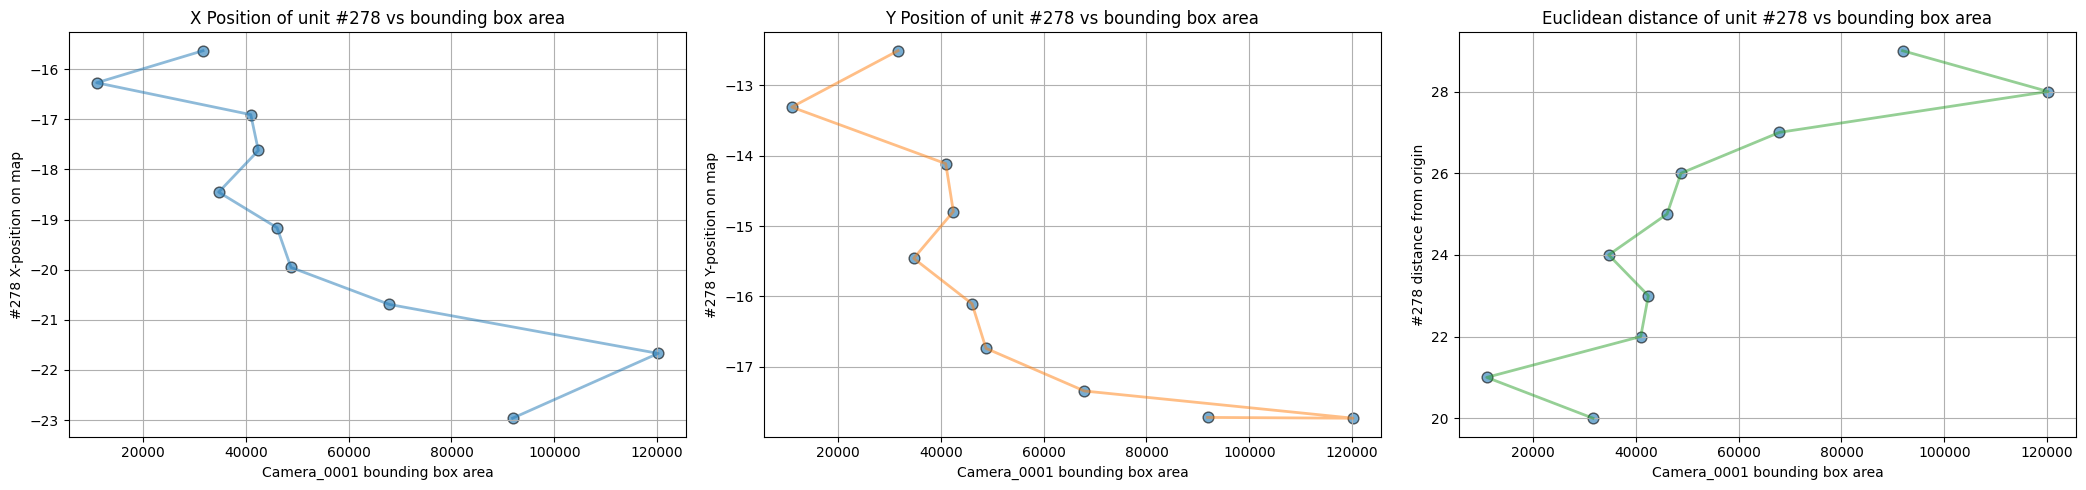

Scatter plot and histogram of camera Camera_0001:


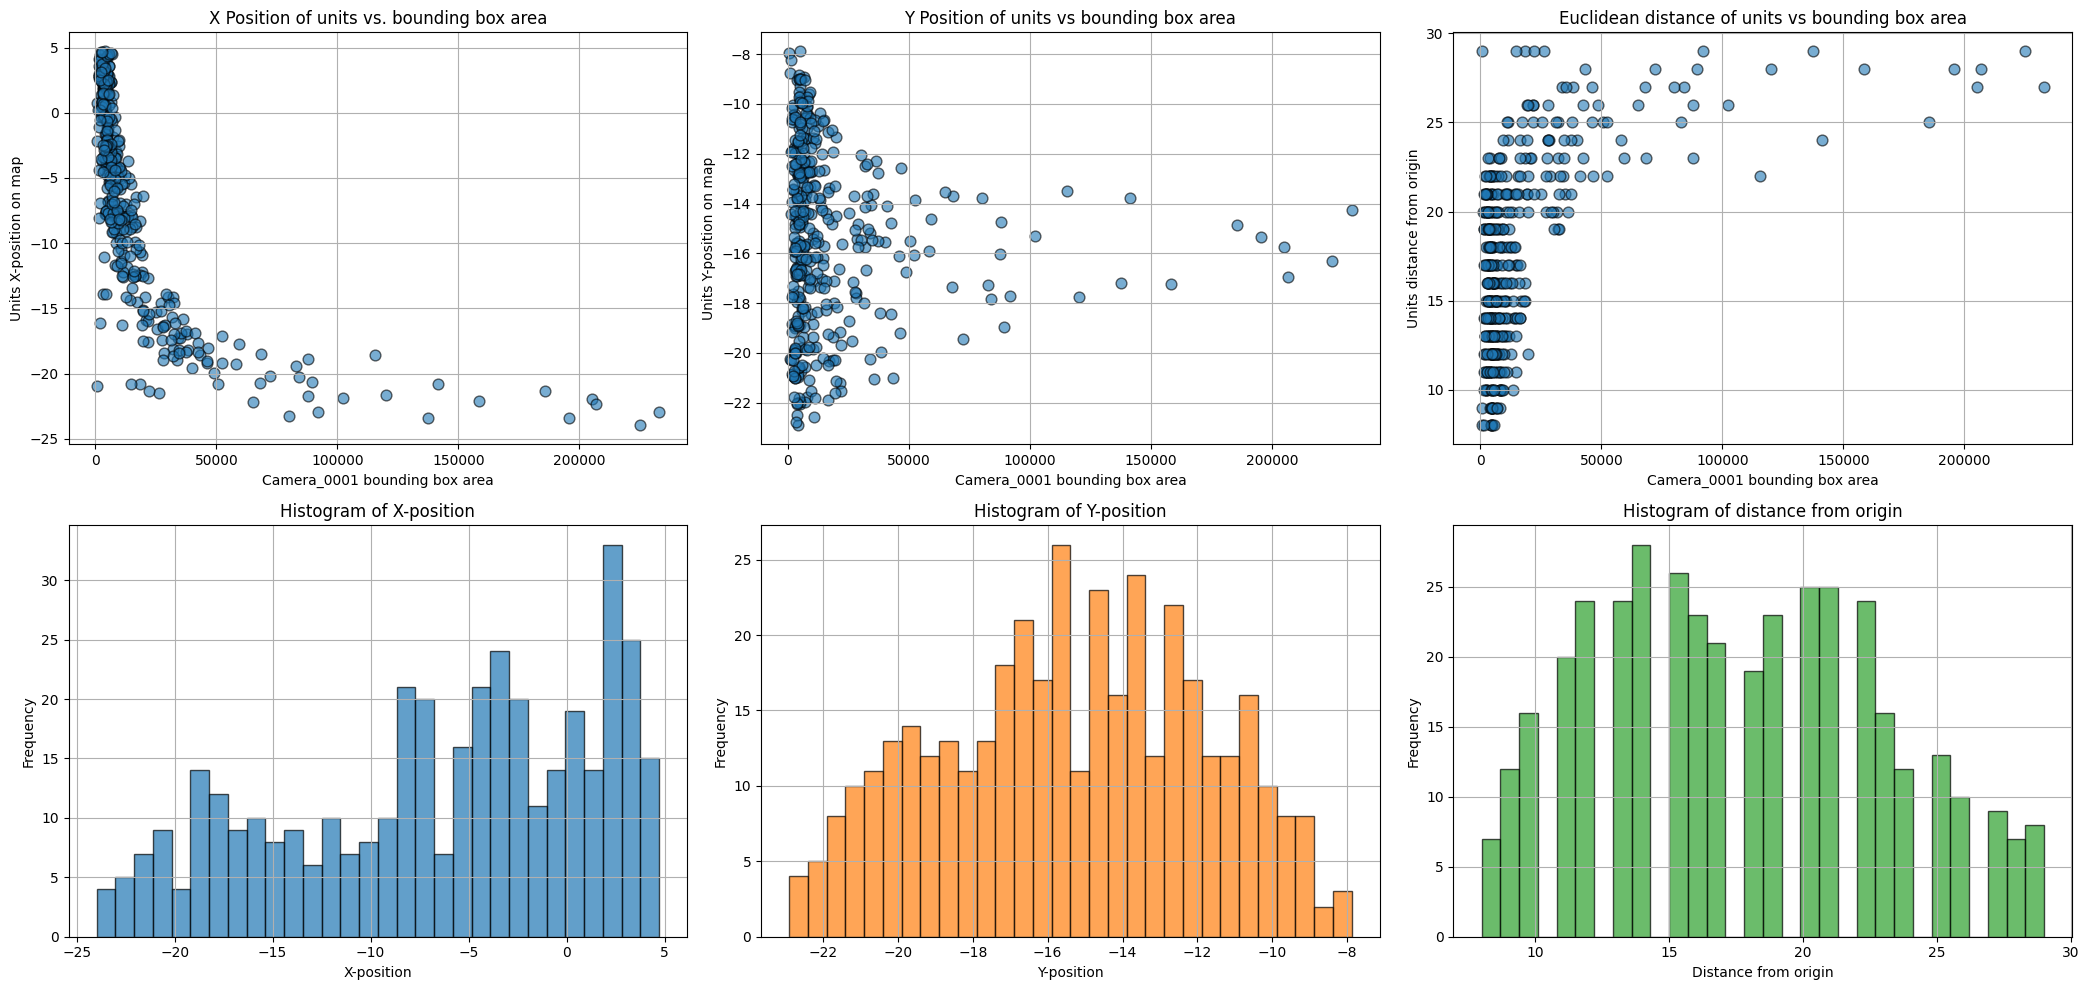

In [7]:
# Data Visualization
# --------------------------------------------------------------
unit_id = 50
sensor_id = 1
# --------------------------------------------------------------
import matplotlib.pyplot as plt
from typing import List
import seaborn as sns
import numpy as np

def plot_unit_distance_vs_sensor_area(bounding_area_df: pd.DataFrame, 
                                      unit_id: int, camera_id: str, 
                                      feature_columns : List):
    
    """Plot Unit Trajectory vs Sensor Bounding Box Area"""

    df = bounding_area_df.copy()
    df[df[feature_columns] == 0] = np.nan
    
    unit_df = df[df.unit_id == unit_id]
    unit_df = unit_df.dropna(subset=[camera_id]).reset_index(drop=True)

    fig, axs = plt.subplots(1, 3, figsize=(21, 5))

    axs[0].scatter(
        unit_df[camera_id], unit_df['x_position'],
        alpha=0.6, s=60, edgecolors='k', linewidths=1
    )
    axs[0].plot(
        unit_df[camera_id], unit_df['x_position'],
        color='tab:blue', alpha=0.5, linewidth=2
    )
    axs[0].set_xlabel(f'{camera_id} bounding box area')
    axs[0].set_ylabel(f'#{unit_id} X-position on map')
    axs[0].set_title(f'X Position of unit #{unit_id} vs bounding box area')
    axs[0].grid(True)

    axs[1].scatter(
        unit_df[camera_id], unit_df['y_position'],
        alpha=0.6, s=60, edgecolors='k', linewidths=1
    )
    axs[1].plot(
        unit_df[camera_id], unit_df['y_position'],
        color='tab:orange', alpha=0.5, linewidth=2
    )
    axs[1].set_xlabel(f'{camera_id} bounding box area')
    axs[1].set_ylabel(f'#{unit_id} Y-position on map')
    axs[1].set_title(f'Y Position of unit #{unit_id} vs bounding box area')
    axs[1].grid(True)

    axs[2].scatter(
        unit_df[camera_id], unit_df['unit_distance_from_origin'],
        alpha=0.6, s=60, edgecolors='k', linewidths=1
    )
    axs[2].plot(
        unit_df[camera_id], unit_df['unit_distance_from_origin'],
        color='tab:green', alpha=0.5, linewidth=2
    )
    axs[2].set_xlabel(f'{camera_id} bounding box area')
    axs[2].set_ylabel(f'#{unit_id} distance from origin')
    axs[2].set_title(f'Euclidean distance of unit #{unit_id} vs bounding box area')
    axs[2].grid(True)

    fig.tight_layout()
    plt.show()

def sensor_distance_scatter(bounding_area_df: pd.DataFrame, 
                            camera_id: str, 
                            feature_columns : List):
    
    """Scatter Plot for a given sensor"""

    df = bounding_area_df.copy()
    df[df[feature_columns] == 0] = np.nan

    df = df.dropna(subset=[camera_id]).reset_index(drop=True)

    fig, axs = plt.subplots(2, 3, figsize=(21, 10))

    axs[0, 0].scatter(
        df[camera_id], df['x_position'],
        alpha=0.6, s=60, edgecolors='k', linewidths=1
    )
    axs[0, 0].set_xlabel(f'{camera_id} bounding box area')
    axs[0, 0].set_ylabel(f'Units X-position on map')
    axs[0, 0].set_title(f'X Position of units vs. bounding box area')
    axs[0, 0].grid(True)

    axs[0, 1].scatter(
        df[camera_id], df['y_position'],
        alpha=0.6, s=60, edgecolors='k', linewidths=1
    )
    axs[0, 1].set_xlabel(f'{camera_id} bounding box area')
    axs[0, 1].set_ylabel(f'Units Y-position on map')
    axs[0, 1].set_title(f'Y Position of units vs bounding box area')
    axs[0, 1].grid(True)

    axs[0, 2].scatter(
        df[camera_id], df['unit_distance_from_origin'],
        alpha=0.6, s=60, edgecolors='k', linewidths=1
    )
    axs[0, 2].set_xlabel(f'{camera_id} bounding box area')
    axs[0, 2].set_ylabel(f'Units distance from origin')
    axs[0, 2].set_title(f'Euclidean distance of units vs bounding box area')
    axs[0, 2].grid(True)

    axs[1, 0].hist(df['x_position'].dropna(), bins=30, color='tab:blue', alpha=0.7, edgecolor='k')
    axs[1, 0].set_xlabel('X-position')
    axs[1, 0].set_ylabel('Frequency')
    axs[1, 0].set_title('Histogram of X-position')
    axs[1, 0].grid(True)

    axs[1, 1].hist(df['y_position'].dropna(), bins=30, color='tab:orange', alpha=0.7, edgecolor='k')
    axs[1, 1].set_xlabel('Y-position')
    axs[1, 1].set_ylabel('Frequency')
    axs[1, 1].set_title('Histogram of Y-position')
    axs[1, 1].grid(True)

    axs[1, 2].hist(df['unit_distance_from_origin'].dropna(), bins=30, color='tab:green', alpha=0.7, edgecolor='k')
    axs[1, 2].set_xlabel('Distance from origin')
    axs[1, 2].set_ylabel('Frequency')
    axs[1, 2].set_title('Histogram of distance from origin')
    axs[1, 2].grid(True)

    fig.tight_layout()
    plt.show()


print(f'The X & Y positions of person #{unit_ids[unit_id]} trajectory, as well as the Euclidean distance from origin (center of map):')
plot_unit_distance_vs_sensor_area(bounding_area_df=df.copy(), 
                                  unit_id=unit_ids[unit_id], 
                                  camera_id=feature_columns[sensor_id],
                                  feature_columns = feature_columns)
print('='* 100)
print(f'Scatter plot and histogram of camera {feature_columns[sensor_id]}:')
sensor_distance_scatter(bounding_area_df=df.copy(), 
                        camera_id=feature_columns[sensor_id],
                        feature_columns = feature_columns)

In [13]:
# model analytics utilities

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import shapiro, probplot

def model_analytics(y_test, y_pred, model_name):
    """Regression Model Residual Analysis"""

    res = y_test - y_pred
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    __, shapiro_p = shapiro(res)

    fig, axs = plt.subplots(1, 3, figsize=(12, 3))
    
    # Residual histogram
    sns.histplot(res, bins=30, kde=True, ax=axs[0], color="tab:blue")
    axs[0].set_title(f"{model_name} Residuals Histogram")
    axs[0].axvline(0, color='k', linestyle='--')
    axs[0].set_xlabel("Residual")
    axs[0].set_ylabel("Frequency")
    
    # Q-Q plot
    probplot(res, dist="norm", plot=axs[1])
    axs[1].set_title(f"{model_name} Residuals Q-Q Plot")
    
    # Predicted vs Actual scatter plot
    sns.scatterplot(x=y_test, y=y_pred, ax=axs[2], color="tab:purple", alpha=0.6)
    axs[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    axs[2].set_title(f"{model_name} Predicted vs Actual")
    axs[2].set_xlabel("Actual")
    axs[2].set_ylabel("Predicted")
    
    plt.tight_layout()
    plt.show()
    
    # stats summary
    print("="*60)
    print(f"        Model: {model_name}")
    print("="*60)
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R^2: {r2:.4f}")
    print(f"Residual Mean: {np.mean(res):.4f}, Residual Std: {np.std(res):.4f}")
    print(f"Shapiro-Wilk Test p-value: {shapiro_p:.6f} (normality {'not rejected' if shapiro_p > 0.05 else 'rejected'})")
    print("="*60)

### Polynomial Regression

Polynomial regression fits a linear model to nonlinear relationships by including polynomial terms of the predictor:

$$
\hat{y} = \beta_0 + \beta_1 x + \beta_2 x^2 + \cdots + \beta_n x^n
$$


Degree 1, CV R²: -0.0729
Degree 2, CV R²: -195.8171
Degree 3, CV R²: -9136.4995


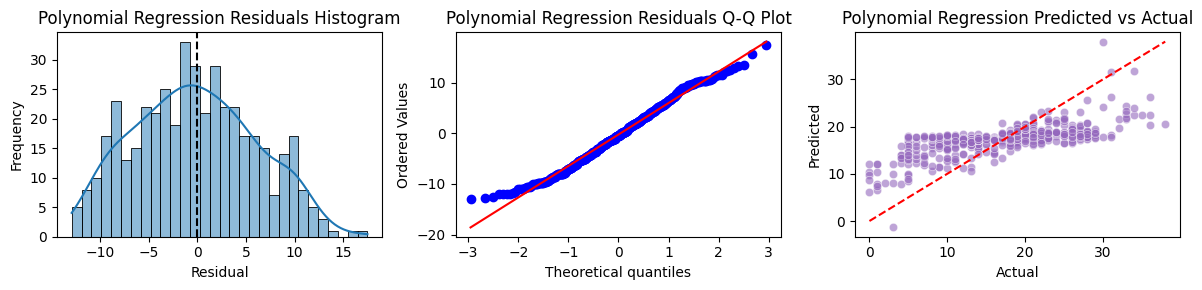

        Model: Polynomial Regression
MSE: 38.6506
RMSE: 6.2170
MAE: 5.1276
R^2: 0.4080
Residual Mean: -0.2410, Residual Std: 6.2123
Shapiro-Wilk Test p-value: 0.000537 (normality rejected)


In [14]:
# Polynomial Regression
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
import numpy as np

best_score = -np.inf
best_deg = 1

for deg in range(1, 4):
    pipe = make_pipeline(
        StandardScaler(),
        PolynomialFeatures(degree=deg, include_bias=False),
        RidgeCV(alphas=np.logspace(-3, 3, 10), cv=5)
    )
    scores = cross_val_score(pipe, X_train, y_train, cv=3, scoring='r2')
    mean_score = np.mean(scores)
    print(f"Degree {deg}, CV R²: {mean_score:.4f}")
    if mean_score > best_score:
        best_score = mean_score
        best_deg = deg

# Final model
poly_model = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(degree=best_deg, include_bias=False),
    RidgeCV(alphas=np.logspace(-3, 3, 10), cv=5)
)
poly_model.fit(X_train, y_train)

# Predict and evaluate
poly_y_pred = poly_model.predict(X_test)
model_analytics(y_test, poly_y_pred, 'Polynomial Regression')


### Generalized Additive Models (GAMs)

GAMs model the response as a sum of smooth functions of predictors:

$$
g(\mathbb{E}[Y]) = \beta_0 + f_1(X_1) + f_2(X_2) + \cdots + f_p(X_p)
$$

- $g$ is a link function.  
- Each $f_j$ is a smooth function.  

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--


Fitting smooth functions:


  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:03
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:03
 27% (3 of 11) |######                   | Elapsed Time: 0:00:01 ETA:   0:00:02
 36% (4 of 11) |#########                | Elapsed Time: 0:00:01 ETA:   0:00:02
 45% (5 of 11) |###########              | Elapsed Time: 0:00:01 ETA:   0:00:02
 54% (6 of 11) |#############            | Elapsed Time: 0:00:02 ETA:   0:00:01
 63% (7 of 11) |###############          | Elapsed Time: 0:00:02 ETA:   0:00:01
 72% (8 of 11) |##################       | Elapsed Time: 0:00:02 ETA:   0:00:01
 81% (9 of 11) |####################     | Elapsed Time: 0:00:03 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:03 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:03 Time:  0:00:03



Smoothing functions penalties (lambda):
[0.0630957344480193]
[0.0630957344480193]
[0.0630957344480193]
[0.0630957344480193]
[0.0630957344480193]
[0.0630957344480193]
[0.0630957344480193]
[0.0630957344480193]
[0.0630957344480193]
[0.0630957344480193]
[0.0630957344480193]
[0.0630957344480193]


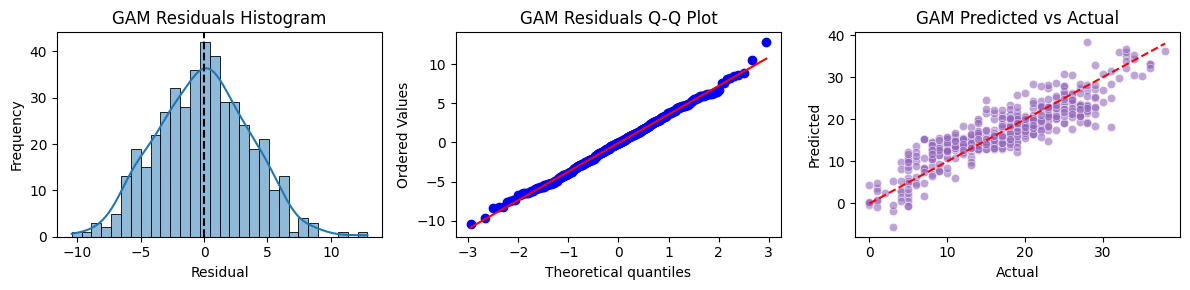

        Model: GAM
MSE: 13.2401
RMSE: 3.6387
MAE: 2.9142
R^2: 0.7972
Residual Mean: -0.0709, Residual Std: 3.6380
Shapiro-Wilk Test p-value: 0.743528 (normality not rejected)


In [15]:
from pygam import LinearGAM, s
from functools import reduce
import operator

print('Fitting smooth functions:')
n_features = X_train.shape[1]
terms = reduce(operator.add, (s(i) for i in range(n_features)))

gam_model = LinearGAM(terms)
gam_model.gridsearch(X_train, y_train)
y_pred_gam = gam_model.predict(X_test)

print('\nSmoothing functions penalties (lambda):')
for lam in gam_model.lam:
    print(lam)

model_analytics(y_test, y_pred_gam, 'GAM')

### Support Vector Machine (SVM)

SVM fits a regression model by finding a function that deviates from the actual targets by a value no greater than $\epsilon$ while keeping the model as flat as possible:

$$
\min_{\mathbf{w}, b} \frac{1}{2} \|\mathbf{w}\|^2
$$

subject to:

$$
\begin{cases}
y_i - (\mathbf{w} \cdot \mathbf{x}_i + b) \leq \epsilon + \xi_i \\
(\mathbf{w} \cdot \mathbf{x}_i + b) - y_i \leq \epsilon + \xi_i^* \\
\xi_i, \xi_i^* \geq 0
\end{cases}
$$

- $\epsilon$-insensitive tube defines a margin of tolerance.  
- Slack variables $\xi_i, \xi_i^*$ allow some errors beyond $\epsilon$. 

Best CV params:
{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


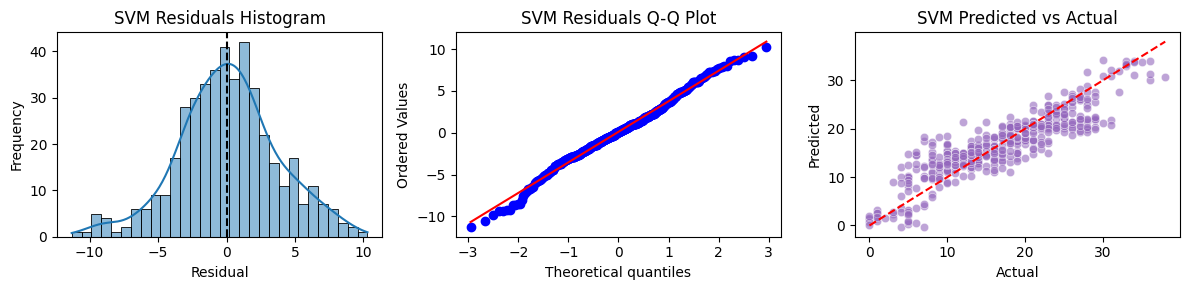

        Model: SVM
MSE: 13.2856
RMSE: 3.6449
MAE: 2.8097
R^2: 0.7965
Residual Mean: 0.1142, Residual Std: 3.6431
Shapiro-Wilk Test p-value: 0.030863 (normality rejected)


In [16]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

svm_params = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf']
}

svm = SVR()
svm_model = GridSearchCV(svm, svm_params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

print(f"Best CV params:\n{svm_model.best_params_}")

model_analytics(y_test, y_pred_svm, 'SVM')

### Random Forest Regression

Random Forest Regression uses an ensemble of decision trees trained on bootstrapped samples with random feature selection:

- Each tree predicts a value for the input.
- The final prediction is the average of all tree predictions.
- Reduces overfitting compared to individual trees.


Best Params: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 100}


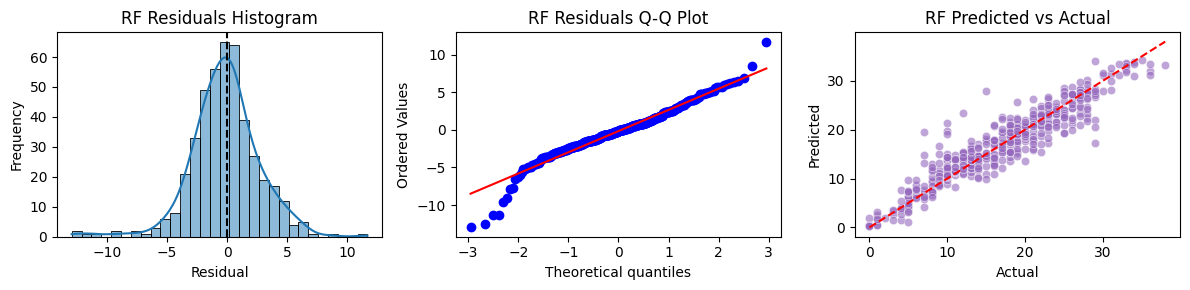

        Model: RF
MSE: 8.2233
RMSE: 2.8676
MAE: 2.0818
R^2: 0.8741
Residual Mean: -0.1642, Residual Std: 2.8629
Shapiro-Wilk Test p-value: 0.000000 (normality rejected)


In [17]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor

rf_models = {}
rf_preds = {}
rf_best_params = {}

rf_params = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

rf = RandomForestRegressor(random_state=42)
rf_model = GridSearchCV(rf, rf_params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("Best Params:", rf_model.best_params_)

model_analytics(y_test, y_pred_rf, 'RF')

### Extreme Gradient Boosting (XGBoost) Regression

XGBoost is an optimized implementation of gradient boosting with enhancements for speed and performance.

- Uses gradient boosting framework to combine weak learners (trees).  
- Includes regularization to reduce overfitting.  

The model updates iteratively:
$$
\hat{f}_m(x) = \hat{f}_{m-1}(x) + \lambda f_m(x)
$$
where $ f_m(x) $ fits the negative gradient of the loss with respect to current predictions, and $ \lambda $ is the learning rate.

XGBoost minimizes a regularized objective:
$$
\mathcal{L}^{(m)} = \sum_{i=1}^n \ell(y_i, \hat{f}_{m-1}(x_i) + f_m(x_i)) + \Omega(f_m)
$$
with $ \Omega(f) = \gamma T + \frac{1}{2} \lambda \sum_{j=1}^T w_j^2 $, where $ T $ is the number of leaves and $ w_j $ are leaf weights.

Hyperparameters include:

- Learning rate $ \lambda$.
- Number of trees.
- Tree depth, subsample and column sampling ratios.
- $L1$ and $L2$ Regularization.


Best Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1}


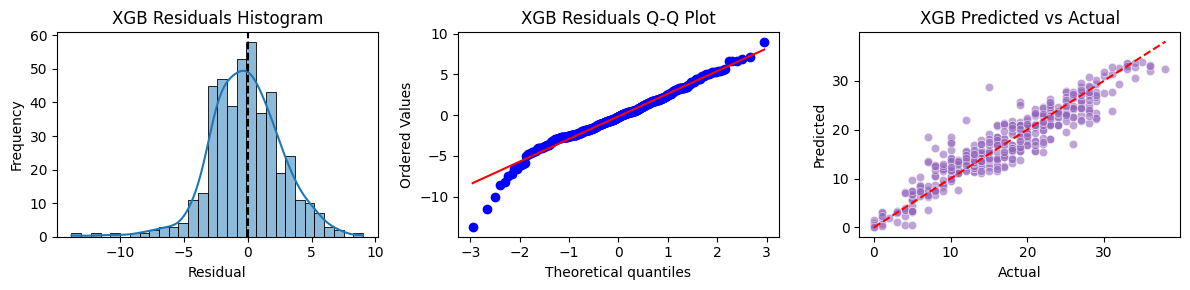

        Model: XGB
MSE: 7.8594
RMSE: 2.8035
MAE: 2.1366
R^2: 0.8796
Residual Mean: -0.1464, Residual Std: 2.7996
Shapiro-Wilk Test p-value: 0.000002 (normality rejected)


In [18]:
from xgboost import XGBRegressor

xgb_params = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'reg_lambda': [0, 1, 10],  # L2 
    'reg_alpha': [0, 0.1, 1]   # L1 
}

xgb = XGBRegressor(random_state=42, verbosity=1)
xgb_model = GridSearchCV(xgb, xgb_params, cv=3, scoring='neg_mean_squared_error', n_jobs=1)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print("Best Params:", xgb_model.best_params_)

model_analytics(y_test, y_pred_xgb, 'XGB')

### Multi-Layer Perceptron (MLP) Regression

MLP is a feedforward neural network with multiple layers of neurons:
      
$$
y = f^{(L)}(W^{(L)} \cdots f^{(1)}(W^{(1)} x + b^{(1)}) + \dots + b^{(L)})
$$
where:

- $x \in \mathbb{R}^d$ is the input feature vector.
- $W^{(l)}$ and $b^{(l)}$ are the weights and biases at layer $l$.
- $f^{(l)}(\cdot)$ is the activation function at layer $l$ (e.g., ReLU, sigmoid).
- $L$ is the total number of layers.
- The composition applies transformations layer-by-layer to produce output $y$.




Best Params: {'activation': 'tanh', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (256, 128, 64), 'learning_rate_init': 0.001, 'max_iter': 1000}


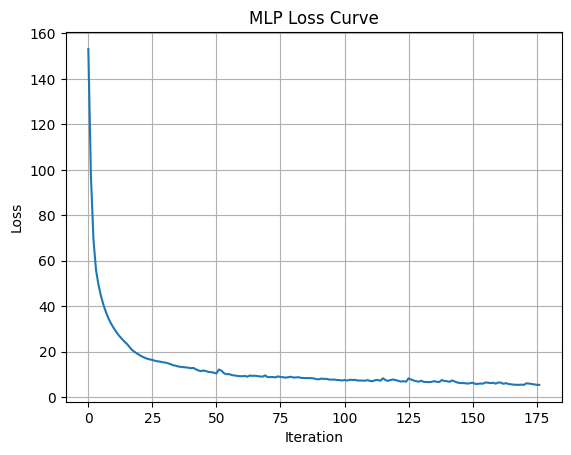

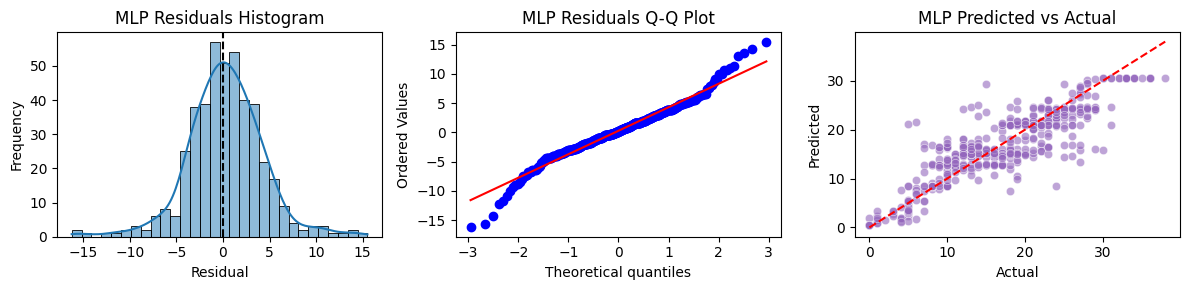

        Model: MLP
MSE: 16.5565
RMSE: 4.0690
MAE: 3.0033
R^2: 0.7464
Residual Mean: 0.2770, Residual Std: 4.0595
Shapiro-Wilk Test p-value: 0.000000 (normality rejected)


In [19]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

mlp_params = {
    'hidden_layer_sizes': [(256, 128, 64), (256, 128, 64, 32)],
    'activation': ['relu', 'tanh'],
    'alpha': [1e-5, 1e-4, 1e-3],
    'learning_rate_init': [0.001, 0.01],
    'early_stopping': [True],
    'max_iter': [1000]
}

mlp = MLPRegressor(
    random_state=42,
    verbose=False,
    early_stopping=True,
    validation_fraction=0.2,
    n_iter_no_change=10
)
mlp_model = GridSearchCV(mlp, mlp_params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
mlp_model.fit(X_train, y_train)
y_pred_mlp = mlp_model.predict(X_test)

print("Best Params:", mlp_model.best_params_)

plt.plot(mlp_model.best_estimator_.loss_curve_)
plt.title(f"MLP Loss Curve")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

model_analytics(y_test, y_pred_mlp, 'MLP')

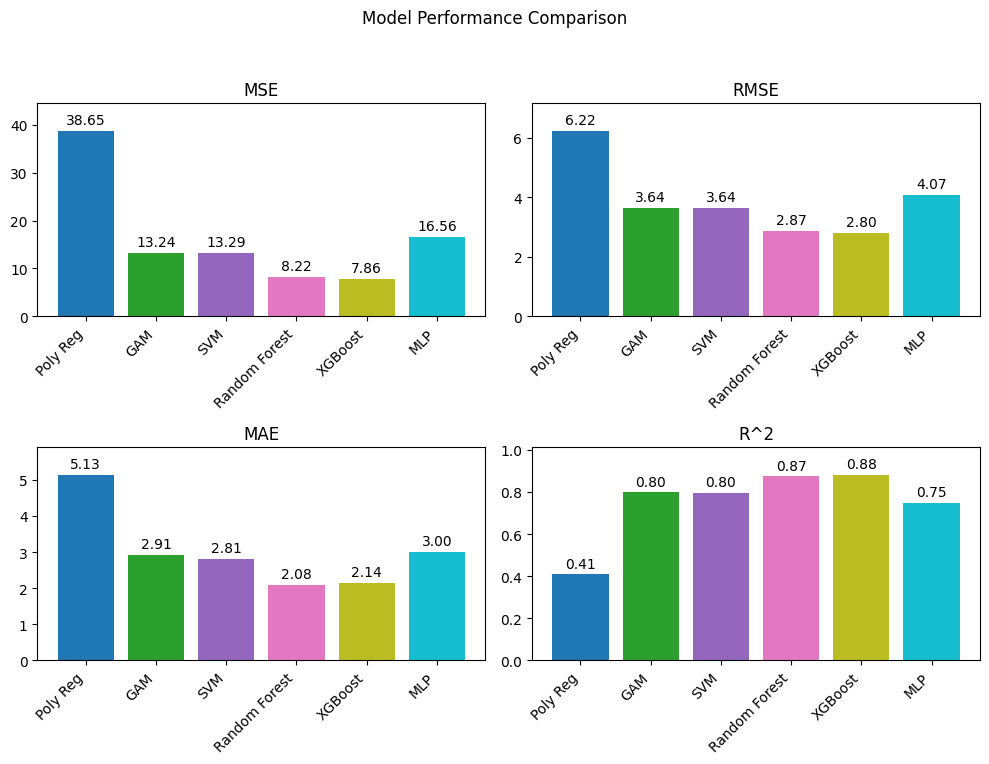

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Only for Euclidean Distance
target_key = 'euclidean_distance'

y_preds = [poly_y_pred, y_pred_gam, y_pred_svm, y_pred_rf, y_pred_xgb, y_pred_mlp]

model_names = ["Poly Reg","GAM","SVM","Random Forest","XGBoost","MLP"]

metrics = {"MSE": [], "RMSE": [], "MAE": [], "R^2": []}

for y_pred in y_preds:
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    metrics["MSE"].append(mse)
    metrics["RMSE"].append(rmse)
    metrics["MAE"].append(mae)
    metrics["R^2"].append(r2)

colors = plt.cm.tab10(np.linspace(0, 1, len(model_names)))

fig, axs = plt.subplots(2, 2, figsize=(10, 8)) 
fig.suptitle('Model Performance Comparison', fontsize=12)

metric_names = list(metrics.keys())
for ax, metric in zip(axs.flat, metric_names):
    values = metrics[metric]
    bars = ax.bar(model_names, values, color=colors)
    ax.set_title(metric, fontsize=12)
    ax.set_xticks(range(len(model_names)))
    ax.set_xticklabels(model_names, rotation=45, ha='right')

    max_val = max(values)
    ax.set_ylim(0, max_val * 1.15)

    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + max_val * 0.02, 
            f'{height:.2f}',
            ha='center',
            va='bottom',
            fontsize=10,
            clip_on=True
        )

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
